In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
DIBUJAR_MODELOS = True

try:
    from tensorflow.keras.utils import plot_model
    import pydot
    pydot.Dot.create(pydot.Dot())
except:
    DIBUJAR_MODELOS = False
    print('No se pudo importar pydot o graphviz, por lo tanto se mostraran resumenes de los modelos enluagr de graficos')
"""Para poder correr la funcion plot_model se tiene que instalar:

Graphviz
pydot

Entonces, si se quieren ver los modelos graficametne poner DIBUJAR_MODELOS = True
De otra manera, solamente se mostrar un resumen del modelo en texto
"""

def mostrarModelo(model,**kargs):
    if DIBUJAR_MODELOS:
        return plot_model(model,**kargs)
    else:
        return model.summary()

"""
Parametros del optimizador de tensorflow:
We then use stochastic gradient descent, with a batch size 128, to optimize the network.
Funcion de coste
We use mean square error as the loss function and Adam as the optimizer.
"""
print('Version de TensorFlow: ',tf.__version__)
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import FEMSections as FEM
import FEMSections.FEM2D.Mesh as Mesh
from FEMSections.FEM2D.Utils import *
from FEMSections.FEM2D.Utils.error import *
import numpy as np
import matplotlib.pyplot as plt
import triangle as tr

Version de TensorFlow:  2.1.0


In [2]:
import FEMSections as FEM
import FEMSections.FEM2D.Mesh as Mesh
from FEMSections.FEM2D.Utils import *
from FEMSections.FEM2D.Utils.error import *

In [2]:
def areaCorrection(ModeloH,errores,K=0.5, alpha=1,area0=1.67):
    
    Areas = K*1/errores**alpha*(K/errores**alpha<=area0)+(K/errores**alpha>area0)*area0
    Areas = np.nan_to_num(Areas, nan=area0)
    ModeloH.graficarSolucionFast(Areas,figsize=None,linewidth=0.1,markersize=0.1,name='Correccion de areas')
    return Areas

<h2>Creacion del dataset</h2>

Integrando elementos [##################################################] 1624/1624
Ensamblando sistema de ecuaciones
Definiendo condiciones deborde
Solucionando sistema de ecuaciones


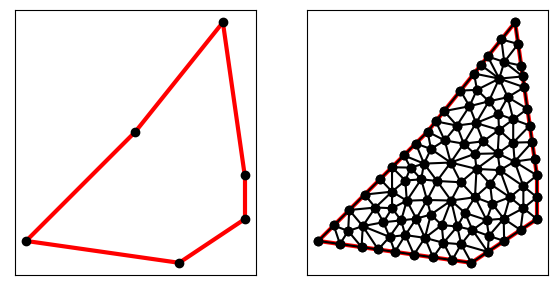

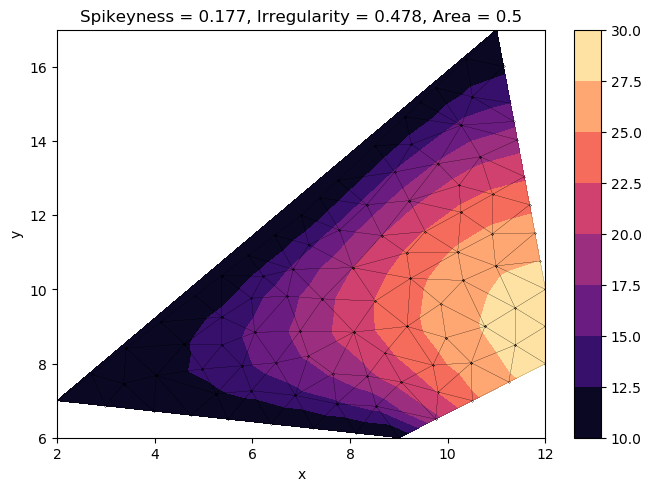

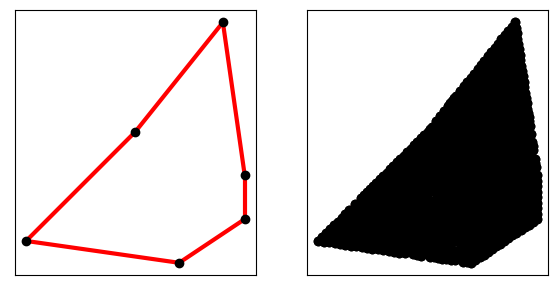

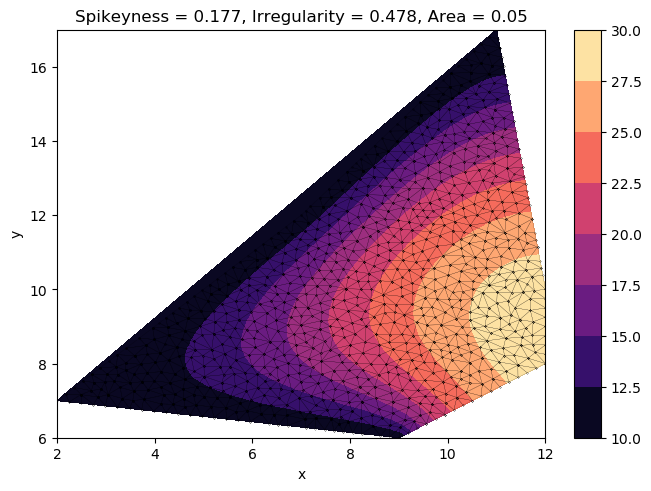

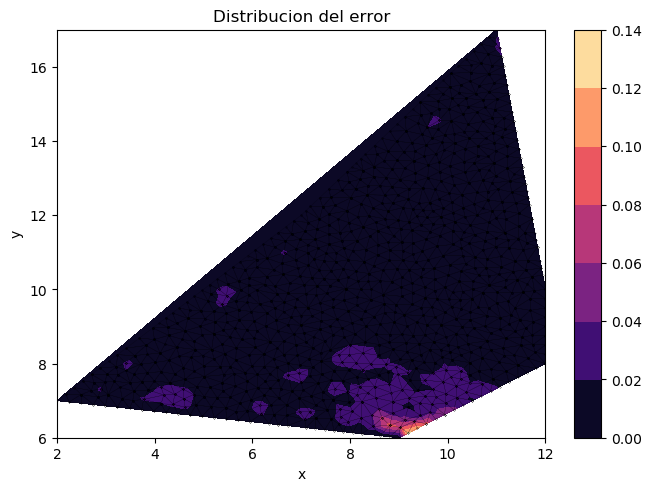

In [3]:
ModeloL,ModeloH = generarPares(geom=1,da1=10,da2=100,bcb=[0,1,2])[0]
errores,U,UG = L1error(ModeloL,ModeloH)

C:\Users\david\Desktop\FEM\2D\FEMSections\FEM2D\Utils\error.py:66: RuntimeWarning: divide by zero encountered in true_divide
  Areas = K*1/errores**alpha*(K/errores**alpha<=area0)+(K/errores**alpha>area0)*area0
C:\Users\david\Desktop\FEM\2D\FEMSections\FEM2D\Utils\error.py:66: RuntimeWarning: invalid value encountered in multiply
  Areas = K*1/errores**alpha*(K/errores**alpha<=area0)+(K/errores**alpha>area0)*area0


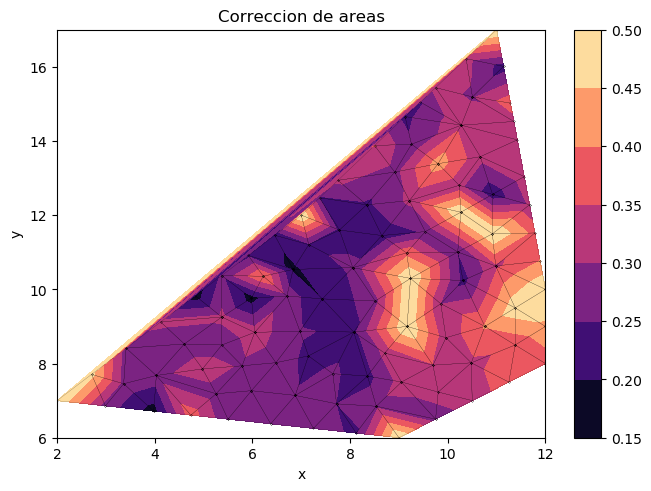

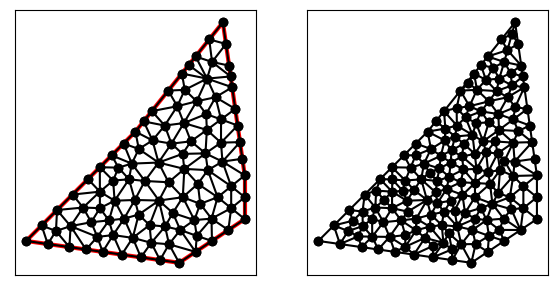

In [8]:
areas = areaCorrection(ModeloL,errores,K=0.004, alpha=1,area0=0.5)
areasR = areasRefinado(ModeloL,areas)
ModeloL.geometria.triangular['triangle_max_area']=np.array(areasR).reshape([len(areasR),1])
tnueva = tr.triangulate(ModeloL.geometria.triangular,'ra')
tr.compare(plt,ModeloL.geometria.triangular,tnueva)


In [9]:
def generarGeometria(triang):
    g = Mesh.Geometria([-1])
    g.triangular = triang
    g.diccionarios = triang['triangles'].tolist()
    g.gdls = triang['vertices'].tolist()
    g.tipos = np.zeros([len(g.diccionarios)]).astype(str)
    g.tipos[:] = 'T1V'
    return g

In [ ]:
zanahorias = FEM.FEM1V(generarGeometria(tnueva))
zanahorias.generarElementos()

a11 = lambda x,y: 1
a12 = lambda x,y: 0
a21 = lambda x,y: 0
a22 = lambda x,y: 1
a00 = lambda x,y: 0

theta = 1
G=1
f = lambda x,y: 2*G*theta
zanahorias.definirCondicionesDeBorde([[0,0],
                                      [1,0],
                                      [2,0],
                                      [3,0],
                                      [4,0]])
zanahorias.solucionar(cmap='magma',markersize=1,linewidth=1,a11=a11,a12=a12,a21=a21,a22=a22,a00=a00,f=f)

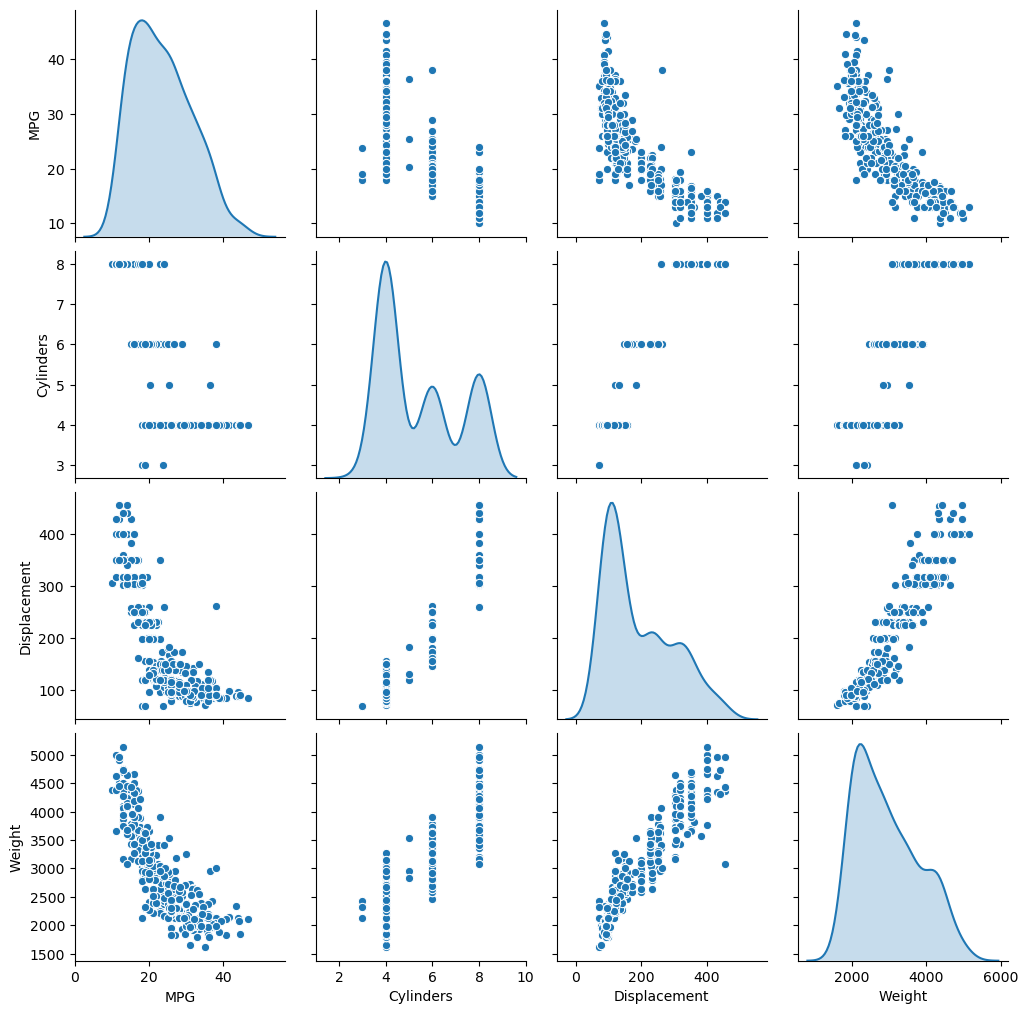

In [4]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight','Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,na_values = "?", comment='\t',sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()

train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [152]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

<H2>Creacion del modelo

In [153]:
def generarResNet(n,tipo):
    """Funcion que retorna el modelo ResNet del paper
    """
    if tipo == 1:
        #Entradas
        inputs = keras.Input(shape=(n), name="Entradas")
        #Bloque 1
        block_1_output = layers.Dense(32, activation="relu", name='Capa_1_32')(inputs)
        x = layers.Dense(32, activation="relu", name='Capa_2_32')(block_1_output)
        x = layers.Dense(64, activation="relu", name='Capa_3_64')(x)
        x = layers.Dense(128, activation="relu", name='Capa_4_128')(x)
        x = layers.Dense(64, activation="relu", name='Capa_5_64')(x)
        x = layers.Dense(32, activation="relu", name='Capa_6_32')(x)
        #Skip Connection
        x = layers.add([block_1_output, x],name='SkipConnection_suma')
        #Bloque 2
        #Salidas
        outputs = layers.Dense(1,activation='relu', name='Capa_7-Salida_1')(x)
        #Modelo completo
        model = keras.Model(inputs, outputs, name="MeshingNet_ResNet")
        
    elif tipo ==2:
        #Entradas
        inputs = keras.Input(shape=(n), name="Entradas-InicioBloque_1")
        #Bloque 1
        block_1_output = layers.Dense(32, activation="relu", name='Capa_1-FinBloque_1')(inputs)
        x = layers.Dense(32, activation="relu", name='Capa_1-InicioBloque_2')(block_1_output)
        x = layers.Dense(32, activation="relu", name='Capa_2-Bloque_2')(x)
        #Bloque 2
        #Skip Connecection 1
        block_2_output = layers.add([x, block_1_output],name='SkipConnection_1-FinBloque_2')
        x = layers.Dense(32, activation="relu", name='Capa_1-Bloque_3')(block_2_output)
        #Bloque 3
        #Skip Connection 2
        block_3_output = layers.add([block_1_output, block_2_output],name='SkipConnection_2')
        x = layers.Dense(32, activation="relu", name='Capa_1-Bloque_4')(block_3_output)
        #Bloque 4
        #Skip Connection 3
        block_4_output = layers.add([block_1_output, block_3_output],name='SkipConnection_3')
        x = layers.Dense(32, activation="relu", name='Capa_1-InicioBloque_4')(block_4_output)
        x = layers.Dense(32, activation="relu", name='Capa_2-Bloque_4')(x)
        #Salidas
        outputs = layers.Dense(1,activation='relu', name='Capa_3-FinBloque_4')(x)
        #Modelo Completo
        model = keras.Model(inputs, outputs, name="MeshingNet_ResNet2")
        
    else:
        raise Exception('El tipo de modelo debe ser 1 o 2')
    #Optimizador del modelo
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',optimizer=optimizer,metrics=['mae', 'mse'])
    return model

<h2>Entrenamiento del modelo</h2>

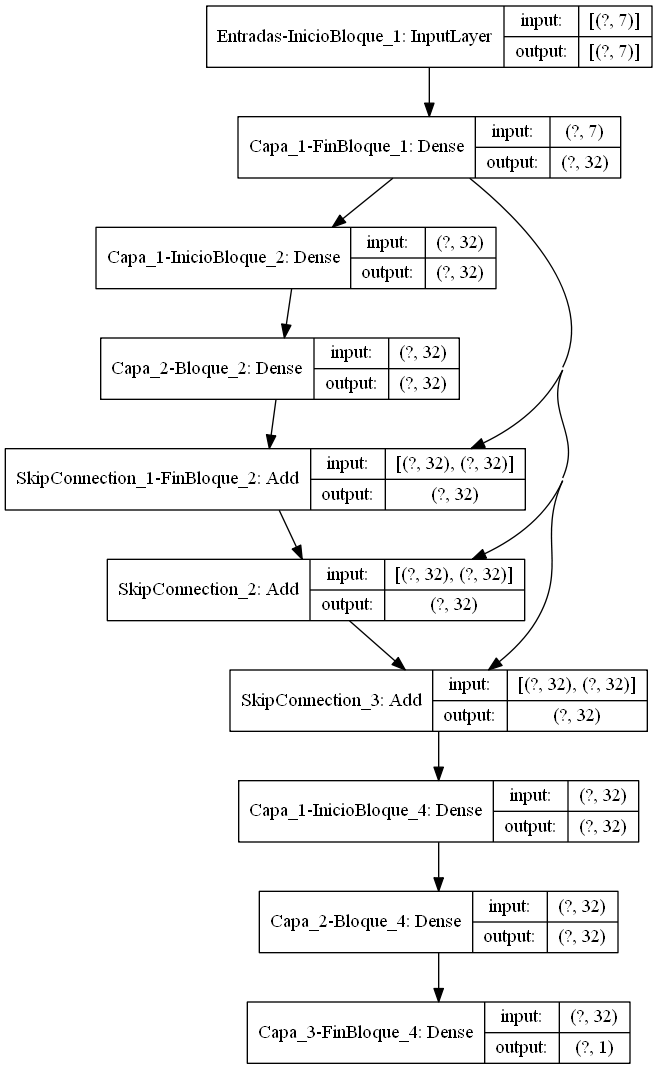

In [154]:
EPOCHS = 1000

n = len(train_dataset.keys())
model = generarResNet(n,tipo=2)
mostrarModelo(model, show_shapes=True)

In [155]:
#Entrenamiento
earlyStop = False
## Early Stop
if earlyStop:
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

    ## Metodo entrenar
    history = model.fit(
      normed_train_data, train_labels,
      epochs=EPOCHS, validation_split = 0.2, verbose=0,
      callbacks=[early_stop,tfdocs.modeling.EpochDots()])
else:
    ## Metodo entrenar
    history = model.fit(
      normed_train_data, train_labels,
      epochs=EPOCHS, validation_split = 0.2, verbose=0,
      callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:nan,  mae:nan,  mse:nan,  val_loss:nan,  val_mae:nan,  val_mse:nan,  
....................................................................................................
Epoch: 100, loss:nan,  mae:nan,  mse:nan,  val_loss:nan,  val_mae:nan,  val_mse:nan,  
....................................................................................................
Epoch: 200, loss:nan,  mae:nan,  mse:nan,  val_loss:nan,  val_mae:nan,  val_mse:nan,  
....................................................................................................
Epoch: 300, loss:nan,  mae:nan,  mse:nan,  val_loss:nan,  val_mae:nan,  val_mse:nan,  
....................................................................................................
Epoch: 400, loss:nan,  mae:nan,  mse:nan,  val_loss:nan,  val_mae:nan,  val_mse:nan,  
....................................................................................................
Epoch: 500, loss:nan,  mae:nan,  mse:nan,  val_loss:nan,  val

<h2>Validacion del modelo</h2>

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,NaN,NaN,NaN,NaN,NaN,NaN,995
996,NaN,NaN,NaN,NaN,NaN,NaN,996
997,NaN,NaN,NaN,NaN,NaN,NaN,997
998,NaN,NaN,NaN,NaN,NaN,NaN,998
999,NaN,NaN,NaN,NaN,NaN,NaN,999


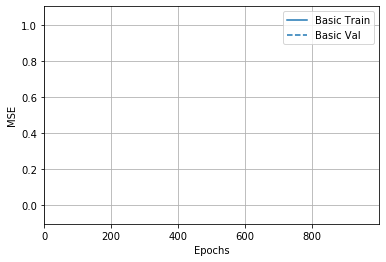

In [156]:
#Estadisticos de validacion
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mse")
plt.ylabel('MSE')
hist.tail()